In [1]:
import os
import json
from matplotlib import pyplot as plt
import numpy as np
from datascience import *
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import tqdm

In [8]:
import json
import tqdm
import math
import numpy as np

def get_unique_moments_from_statvu(statvu_log_path):
    """
    Extracts unique moments from a StatVu log file.

    Args:
    statvu_log_path (str): The file path of the StatVu log.

    Returns:
    dict: A dictionary mapping unique quarter-time remaining combinations to their respective moment details.
    """
    with open(statvu_log_path, 'r') as file:
        data = json.load(file)

    unique_quarter_time_combinations = set()
    processed_moments = {}

    for event in data['events']:
        for moment in event['moments']:
            quarter, moment_id, time_remaining_quarter, time_remaining_shot_clock, _, positions = moment
            moment_identifier = f"{quarter}_{time_remaining_quarter}"
            if moment_identifier not in unique_quarter_time_combinations:
                player_positions = [
                    {'team_id': player_data[0], 'player_id': player_data[1], 
                     'x_position': player_data[2], 'y_position': player_data[3], 'z_position': player_data[4]}
                    for player_data in positions
                ]
                processed_moments[moment_identifier] = {
                    'quarter': quarter,
                    'moment_id': moment_id,
                    'time_remaining_in_quarter': time_remaining_quarter,
                    'time_remaining_on_shot_clock': time_remaining_shot_clock,
                    'player_positions': player_positions
                }
                unique_quarter_time_combinations.add(moment_identifier)

    return processed_moments


def update_timestamps(timestamps, time_remaining):
    for k, v in enumerate(time_remaining):
        timestamps[str(k)]['time_remaining'] = v
    return timestamps


def get_timestamps_from_fp(fp):
    with open(fp, 'r') as f:
        timestamps = json.load(f)
    return timestamps


def get_time_remaining_from_timestamps_fp(fp):
    timestamps = get_timestamps_from_fp(fp)
    return get_time_remaining_from_timestamps(timestamps)


def get_time_remaining_from_timestamps(timestamps):
    return np.array([v['time_remaining'] if v['time_remaining'] is not None else 0 for v in timestamps.values()])


def post_process_timestamps(timestamps):
    """
    Optimized version of the original function using NumPy for efficiency.
    """

    def extend_timestamps(time_remaining):
        time_array = np.array(time_remaining, dtype=np.float32)
        time_array = np.where(time_array == None, np.nan, time_array)
        valid_mask = np.isnan(time_array)
        last_valid = np.fmax.accumulate(np.where(valid_mask, np.nan, time_array))
        time_array[valid_mask] = last_valid[valid_mask]
        return np.where(np.isnan(time_array), None, time_array).tolist()

    def interpolate(time_remaining):
        fps = 30
        multiplier = 0
        decreasing = False
        for i in range(len(time_remaining) - 1):
            current, next_value = time_remaining[i], time_remaining[i + 1]
            peak_value = time_remaining[min(i + fps, len(time_remaining) - 1)]
            if current == 0:
                continue
            decreasing = peak_value < current
            if decreasing:
                if multiplier > 30:
                    multiplier, decreasing = 0, False
                    continue
                time_remaining[i] -= round((1/30) * multiplier, 2)
                multiplier = 0 if next_value < current else multiplier + 1
        return time_remaining

    def moving_average(x, window):
        return np.convolve(x, np.ones(window), 'valid') / window

    def normalize(arr):
        _min, _max = np.min(arr), np.max(arr)
        return (arr - _min) / (_max - _min)

    def denoise_time_remaining(time_remaining):
        def update_time_remaining(remove_indices, time_array):
            valid_indices = np.where(remove_indices == 0)[0]
            for idx in np.where(remove_indices)[0]:
                nearest_valid_index = valid_indices[np.argmin(np.abs(valid_indices - idx))]
                time_array[idx] = time_array[nearest_valid_index]

        time_array = np.array(time_remaining, dtype=np.float32)
        expected = np.linspace(100, 720, len(time_array), endpoint=False)[::-1]
        norm_expected_diff = normalize(np.abs(expected - time_array))
        remove_indices = norm_expected_diff > 0.5
        update_time_remaining(remove_indices, time_array)

        for window in [1000, 500, 50, 10, 5]:
            if len(time_array) > window:
                mvg_avg = moving_average(time_array, window)
                padded_avg = np.pad(mvg_avg, (window // 2, window - window // 2 - 1), mode='edge')
                norm_diff = normalize(np.abs(time_array - padded_avg))
                remove_indices = norm_diff > 0.5
                update_time_remaining(remove_indices, time_array)

        temp_interpolated = interpolate(time_array)
        delta = np.gradient(temp_interpolated)
        delta_inter = normalize(moving_average(np.abs(delta), 7))
        remove_indices = delta_inter > 0.1
        update_time_remaining(remove_indices, time_array)
        return time_array

    def remove_delta_zero(a, b):
        if len(a) != len(b):
            raise ValueError("The arrays 'a' and 'b' must be of equal length.")
        a = np.array(a, dtype=np.float32)
        b = np.array(b, dtype=np.float32)
        a[b == 0] = np.nan
        return a

    time_remaining = get_time_remaining_from_timestamps(timestamps)
    extended_time_remaining = extend_timestamps(time_remaining)
    denoised_time_remaining = denoise_time_remaining(extended_time_remaining)
    interpolated_time_remaining = interpolate(denoised_time_remaining)

    # remove values where delta = 0
    delta_time_remaining = np.gradient(interpolated_time_remaining)
    remove_delta_zero(interpolated_time_remaining, delta_time_remaining)

    timestamps = update_timestamps(
        timestamps=timestamps,
        time_remaining=interpolated_time_remaining
    )
    return timestamps


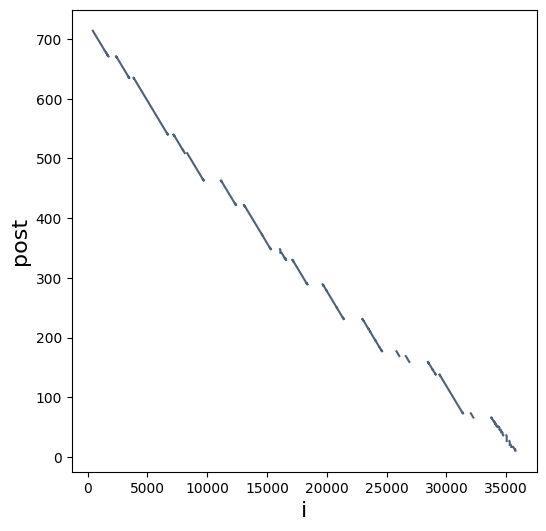

In [9]:
ts_path = '/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps'
ts_paths = [os.path.join(ts_path, f) for f in os.listdir(ts_path)]

ep = ts_paths[0]
ts = get_timestamps_from_fp(ep)
ts_pp = post_process_timestmaps(ts)

tr_pre = get_time_remaining_from_timestamps_fp(ep)
tr_post = get_time_remaining_from_timestamps(ts_pp)
delta_time_remaining = np.gradient(tr_post)

expected = np.linspace(-50, 720, len(tr_pre), endpoint=False)[::-1]
expected[expected < 0] = 0

t = Table().with_columns(
    'i', np.arange(0, len(tr_pre)),
    # 'pre', tr_pre,
    'post', tr_post,
    # 'delta', delta_time_remaining,
    # 'expected', expected
)
t.plot('i')